# Empirical Analysis of Maximization Bias in Deep RL

This notebook investigates the phenomenon of value overestimation (maximization bias) in standard Q-learning algorithms. We develop a modular Deep RL framework to train agents in the `LunarLander-v3` environment, implementing both standard Deep Q-Networks (DQN) and Double DQN (DDQN) from scratch. 

By periodically comparing the agents' internal Q-value estimates against true Monte Carlo returns, we will empirically demonstrate how DDQN decouples action selection from evaluation to mathematically reduce this bias.

In [ ]:
# 1. Install system dependencies for Box2D
!apt-get update
!apt-get install -y swig

# 2. Install the Python packages
!pip install gymnasium[box2d] torch numpy matplotlib pandas

# 3. Import everything
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import deque
import copy

# 4. Check device (Should now say 'cuda' if Step 1 worked)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

## 1. Network Architecture and Experience Replay

To approximate the optimal action-value function, we use a multi-layer perceptron (MLP). Because sequential environment interactions are highly correlated, we also implement an **Experience Replay Buffer**. By sampling randomized mini-batches of past transitions, we break these correlations and stabilize neural network training.

In [2]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=64):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return (np.array(state), np.array(action), np.array(reward),
                np.array(next_state), np.array(done))

    def __len__(self):
        return len(self.buffer)

## 2. The Unified DQN & Double DQN Agent

This agent class can toggle between standard DQN and Double DQN. The core difference lies in how the Temporal Difference (TD) target is calculated.

In standard **DQN**, the target network uses a single $\max$ operator for both selecting and evaluating the next action, which inherently introduces a positive bias:
$$Y_t = R_{t+1} + \gamma \max_a Q(S_{t+1}, a; \theta^-)$$

In **Double DQN**, we mitigate this by decoupling the process. We use the local/online network ($\theta$) to *select* the best action, but the target network ($\theta^-$) to *evaluate* it:
$$Y_t = R_{t+1} + \gamma Q(S_{t+1}, \arg\max_a Q(S_{t+1}, a; \theta); \theta^-)$$

In [3]:
class DQNAgent:
    def __init__(self, state_size, action_size, is_double_dqn=False,
                 lr=5e-4, gamma=0.99, tau=1e-3):
        self.state_size = state_size
        self.action_size = action_size
        self.is_double_dqn = is_double_dqn
        self.gamma = gamma
        self.tau = tau

        # Networks
        self.q_network = QNetwork(state_size, action_size).to(device)
        self.target_network = QNetwork(state_size, action_size).to(device)
        self.target_network.load_state_dict(self.q_network.state_dict())

        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)

    def act(self, state, epsilon=0.0):
        if random.random() > epsilon:
            state = torch.FloatTensor(state).unsqueeze(0).to(device)
            with torch.no_grad():
                action_values = self.q_network(state)
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences

        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(device)

        # Get expected Q values from local model
        Q_expected = self.q_network(states).gather(1, actions)

        # Get max predicted Q values for next states
        with torch.no_grad():
            if self.is_double_dqn:
                # DDQN: Decouple selection from evaluation
                best_actions = self.q_network(next_states).argmax(dim=1, keepdim=True)
                Q_targets_next = self.target_network(next_states).gather(1, best_actions)
            else:
                # Standard DQN
                Q_targets_next = self.target_network(next_states).max(1)[0].unsqueeze(1)

        # Compute Q targets for current states
        Q_targets = rewards + (self.gamma * Q_targets_next * (1 - dones))

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)

        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Soft update target network
        self.soft_update(self.q_network, self.target_network)

    def soft_update(self, local_model, target_model):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(self.tau * local_param.data + (1.0 - self.tau) * target_param.data)

## 3. Measuring Maximization Bias: Monte Carlo vs. Q-Values

To empirically prove the existence of maximization bias, we cannot rely on training loss. Instead, we must periodically halt training and compare two metrics across a fixed set of states:
1. **Estimated Q-Values:** What the neural network *predicts* its future discounted return will be.
2. **True Monte Carlo Returns:** The *actual* accumulated discounted rewards achieved by unrolling the current greedy policy to the end of the episode.

In [4]:
def evaluate_bias(env, agent, eval_states, num_episodes=5):
    """
    Returns the average estimated Q-value for a set of states,
    and the average true Monte Carlo return of the current policy.
    """
    # 1. Estimated Q-values
    agent.q_network.eval()
    states_tensor = torch.FloatTensor(np.array(eval_states)).to(device)
    with torch.no_grad():
        q_values = agent.q_network(states_tensor)
        max_q_values = q_values.max(dim=1)[0].cpu().numpy()
    avg_estimated_q = np.mean(max_q_values)
    agent.q_network.train()

    # 2. True Monte Carlo Returns
    true_returns = []
    for _ in range(num_episodes):
        state, _ = env.reset()
        episode_return = 0
        discount = 1.0
        done = False
        truncated = False
        while not (done or truncated):
            action = agent.act(state, epsilon=0.0) # Greedy policy
            next_state, reward, done, truncated, _ = env.step(action)
            episode_return += discount * reward
            discount *= agent.gamma
            state = next_state
        true_returns.append(episode_return)

    avg_true_return = np.mean(true_returns)
    return avg_estimated_q, avg_true_return

## 4. Execution and Training

We now train both the standard DQN and the Double DQN agents. During training, we periodically call our evaluation function to track the divergence between estimated Q-values and true returns.

In [6]:
def train_agent(is_double_dqn, env_name="LunarLander-v3", n_episodes=600):
    env = gym.make(env_name)
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    agent = DQNAgent(state_size, action_size, is_double_dqn=is_double_dqn)
    memory = ReplayBuffer(capacity=100000)

    batch_size = 64
    epsilon = 1.0
    epsilon_min = 0.01
    epsilon_decay = 0.995

    # Collect fixed states for stable bias evaluation
    fixed_states = []
    state, _ = env.reset()
    for _ in range(100):
        action = env.action_space.sample()
        next_state, _, done, truncated, _ = env.step(action)
        fixed_states.append(state)
        state = next_state
        if done or truncated:
            state, _ = env.reset()

    metrics = {'rewards': [], 'estimated_qs': [], 'true_returns': []}

    for e in range(n_episodes):
        state, _ = env.reset()
        score = 0
        done, truncated = False, False

        while not (done or truncated):
            action = agent.act(state, epsilon)
            next_state, reward, done, truncated, _ = env.step(action)
            memory.push(state, action, reward, next_state, done or truncated)

            state = next_state
            score += reward

            if len(memory) > batch_size:
                experiences = memory.sample(batch_size)
                agent.learn(experiences)

        epsilon = max(epsilon_min, epsilon_decay * epsilon)
        metrics['rewards'].append(score)

        # Evaluate bias periodically
        if (e + 1) % 20 == 0:
            est_q, true_ret = evaluate_bias(env, agent, fixed_states)
            metrics['estimated_qs'].append(est_q)
            metrics['true_returns'].append(true_ret)
            print(f"Episode {e+1}\tScore: {score:.2f}\tEst. Q: {est_q:.2f}\tTrue Return: {true_ret:.2f}")

    env.close()
    return metrics

print("--- Training Standard DQN ---")
dqn_metrics = train_agent(is_double_dqn=False)

print("\n--- Training Double DQN ---")
ddqn_metrics = train_agent(is_double_dqn=True)

--- Training Standard DQN ---
Episode 20	Score: -118.39	Est. Q: 2.91	True Return: -117.93
Episode 40	Score: -173.89	Est. Q: 4.73	True Return: -53.38
Episode 60	Score: -312.73	Est. Q: 7.09	True Return: -55.04
Episode 80	Score: -52.79	Est. Q: 9.73	True Return: -7.99
Episode 100	Score: -85.35	Est. Q: 12.35	True Return: 5.50
Episode 120	Score: 29.21	Est. Q: 15.17	True Return: 14.25
Episode 140	Score: -180.38	Est. Q: 19.43	True Return: 21.19
Episode 160	Score: -2.04	Est. Q: 24.81	True Return: 30.24
Episode 180	Score: 60.29	Est. Q: 30.84	True Return: 23.55
Episode 200	Score: 6.55	Est. Q: 36.42	True Return: 45.38
Episode 220	Score: -4.49	Est. Q: 44.71	True Return: 22.91
Episode 260	Score: 36.87	Est. Q: 58.00	True Return: 38.40
Episode 280	Score: 82.36	Est. Q: 61.01	True Return: 30.42
Episode 300	Score: 290.35	Est. Q: 62.49	True Return: 58.37
Episode 320	Score: 260.96	Est. Q: 62.97	True Return: 59.67
Episode 340	Score: 226.26	Est. Q: 69.13	True Return: 50.03
Episode 360	Score: 222.21	Est. Q: 7

## 5. Visualizing the Results

Finally, we plot our collected metrics. The left plot visualizes the core thesis of this project: the overestimation gap (maximization bias) between predicted and actual returns. The right plot tracks the smoothed episodic scores to ensure both agents successfully learned optimal policies for the environment.

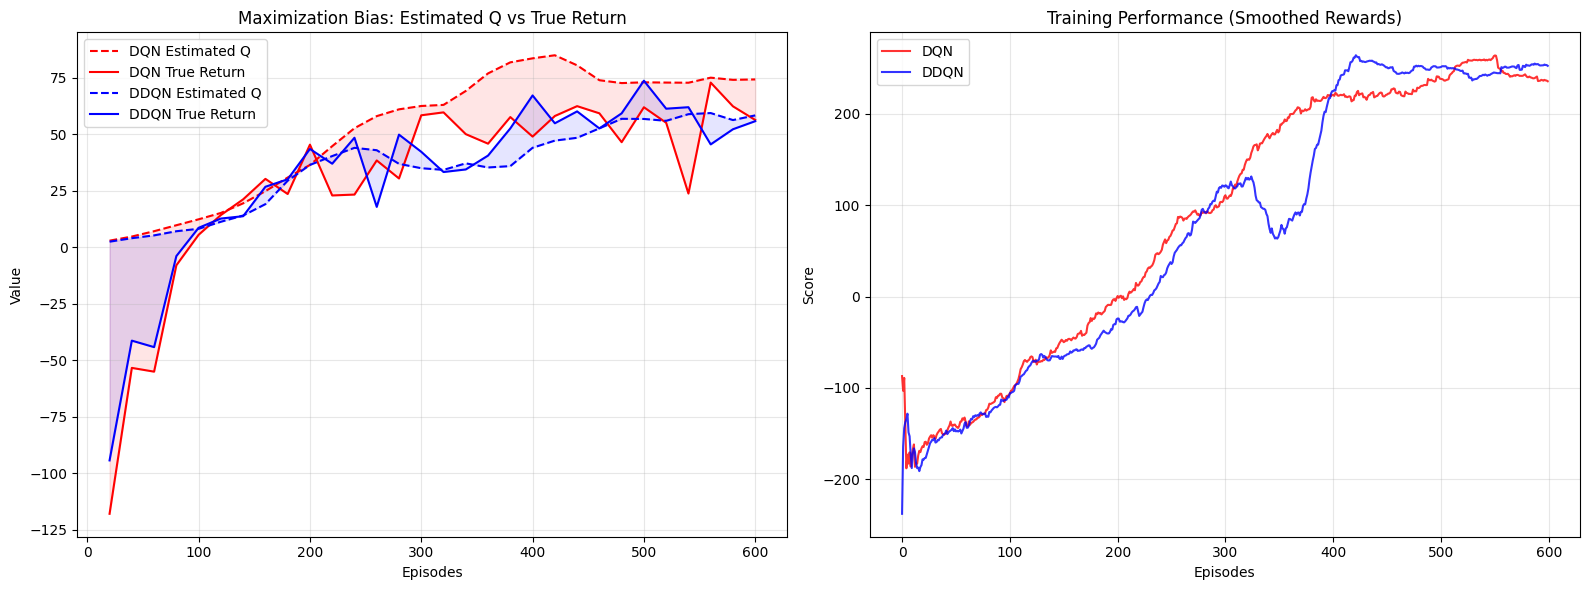

In [8]:
import pandas as pd

def plot_results(dqn_metrics, ddqn_metrics):
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    # Plot 1: Overestimation Bias
    eval_episodes = np.arange(20, len(dqn_metrics['estimated_qs']) * 20 + 1, 20)

    axs[0].plot(eval_episodes, dqn_metrics['estimated_qs'], label='DQN Estimated Q', color='red', linestyle='--')
    axs[0].plot(eval_episodes, dqn_metrics['true_returns'], label='DQN True Return', color='red')
    axs[0].plot(eval_episodes, ddqn_metrics['estimated_qs'], label='DDQN Estimated Q', color='blue', linestyle='--')
    axs[0].plot(eval_episodes, ddqn_metrics['true_returns'], label='DDQN True Return', color='blue')

    axs[0].fill_between(eval_episodes, dqn_metrics['estimated_qs'], dqn_metrics['true_returns'], color='red', alpha=0.1)
    axs[0].fill_between(eval_episodes, ddqn_metrics['estimated_qs'], ddqn_metrics['true_returns'], color='blue', alpha=0.1)

    axs[0].set_title('Maximization Bias: Estimated Q vs True Return')
    axs[0].set_xlabel('Episodes')
    axs[0].set_ylabel('Value')
    axs[0].legend()
    axs[0].grid(True, alpha=0.3)

    # Plot 2: Training Performance (Smoothed)
    def smooth(data, window=50):
        return pd.Series(data).rolling(window, min_periods=1).mean()

    axs[1].plot(smooth(dqn_metrics['rewards']), label='DQN', color='red', alpha=0.8)
    axs[1].plot(smooth(ddqn_metrics['rewards']), label='DDQN', color='blue', alpha=0.8)
    axs[1].set_title('Training Performance (Smoothed Rewards)')
    axs[1].set_xlabel('Episodes')
    axs[1].set_ylabel('Score')
    axs[1].legend()
    axs[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_results(dqn_metrics, ddqn_metrics)